## 数据探索

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import xgboost as xgb
from sklearn.metrics import make_scorer

%matplotlib inline
plt.style.use(u'fivethirtyeight')

path = '/Users/zhouzhirui/Documents/data/zillow/'
os.chdir(path)
os.listdir()

properties = pd.read_csv('properties_2016.csv')
train = pd.read_csv('train_2016_v2.csv',parse_dates=["transactiondate"])
properties_info = pd.read_csv('featureInfo_utf8.csv')

/Users/zhouzhirui/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


> map columns name

In [5]:
map_dict = dict(zip(properties_info.Feature,properties_info.feature_map))
properties.columns = map(lambda x: map_dict[x], properties.columns)

## Train Data Set

### logerror

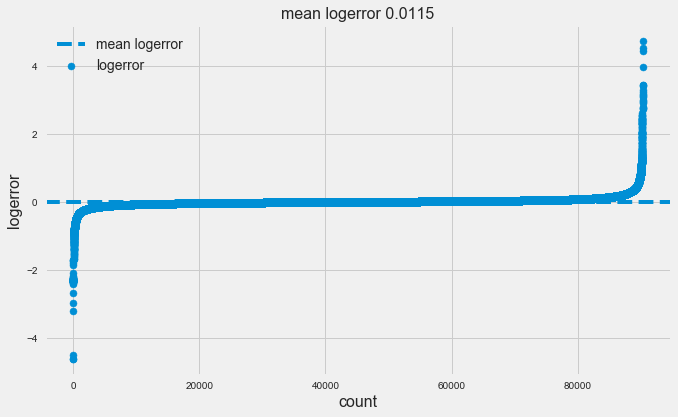

In [5]:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(range(train.shape[0]), np.sort(train.logerror.values),label='logerror')
ax.set_ylabel('logerror',size=16)
ax.set_xlabel('count',size=16)
ax.axhline(train.logerror.mean(),linestyle='--',label='mean logerror')
ax.legend(fontsize=14)
ax.set_title('mean logerror %.4f'%(train.logerror.mean()), size=16)

/Users/zhouzhirui/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/Users/zhouzhirui/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


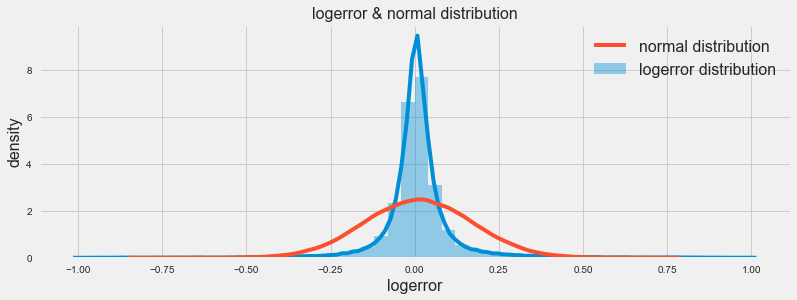

In [6]:
fig, ax = plt.subplots(figsize=(12,4))
sns.distplot(train.logerror.where((train.logerror<1)&(train.logerror>-1)).dropna(),label='logerror distribution')
sns.distplot(sp.stats.norm.rvs(sp.stats.tmean(train.logerror), 
                  sp.stats.tstd(train.logerror),
                  size=train.shape[0]), hist=False, label='normal distribution')
ax.set_xlabel('logerror', size=16)
ax.set_ylabel('density', size=16)
ax.legend(fontsize=16)
ax.set_title('logerror & normal distribution', size=16)

In [7]:
(train.groupby(np.sign(train.logerror))['logerror'].agg(['count','mean','std','min','max','median']))\
.rename(index={-1:'negative logerror',0:'zero logerror',1:'positive logerror'})

,count,mean,std,min,max,median
logerror,,,,,,
negative logerror,39667,-0.064849,0.134954,-4.605,-0.001,-0.0315
zero logerror,847,0.000000,0.000000,0.000,0.000,0.0000
positive logerror,49761,0.072480,0.155518,0.001,4.737,0.0344


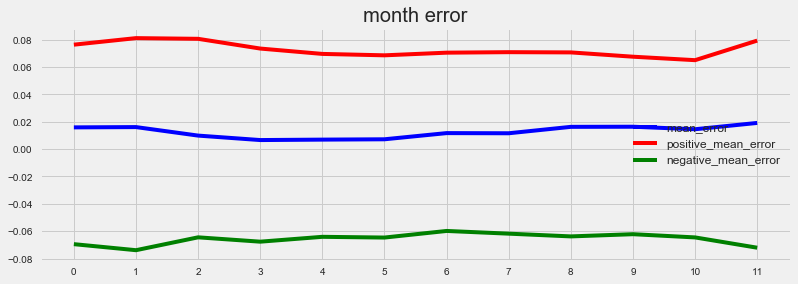

In [8]:
error_mean = train.groupby(train.transactiondate.apply(lambda x: x.month))['logerror'].mean()
p_error_mean = train[train.logerror>0].groupby(train[train.logerror>0].transactiondate.apply(lambda x: x.month))['logerror'].mean()
n_error_mean = train[train.logerror<0].groupby(train[train.logerror<0].transactiondate.apply(lambda x: x.month))['logerror'].mean()

fig, ax =plt.subplots(figsize=(12,4))
ax.plot(range(12),error_mean, label='mean_error', c='blue')
ax.plot(range(12),p_error_mean, label='positive_mean_error', c='red')
ax.plot(range(12),n_error_mean, label='negative_mean_error', c='g')
ax.legend(fontsize=12,loc='center right')
ax.set_xticks(range(12))
ax.set_title('month error')

### 重复交易

In [9]:
(train.groupby('parcelid')['logerror'].count().reset_index()).groupby('logerror').count()

,parcelid
logerror,
1,90026
2,123
3,1


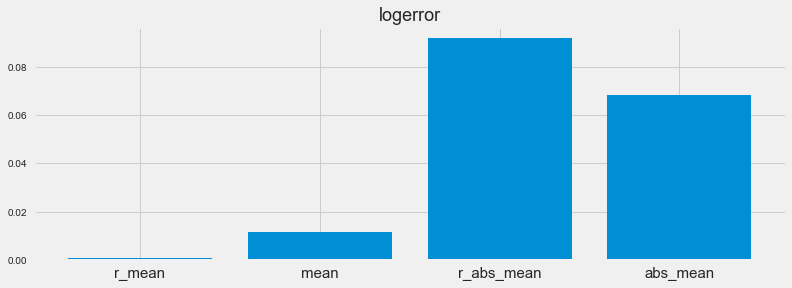

In [13]:
parcelid_t_count = train.groupby('parcelid')['logerror'].count().reset_index().rename(columns={'logerror':'transaction_count'})
parcelid_repeat_teansaction = parcelid_t_count[parcelid_t_count.transaction_count>1].parcelid.values

r_mean = train[train.parcelid.isin(parcelid_repeat_teansaction)].logerror.mean()

_mean = train.logerror.mean()

r_abs_mean = train[train.parcelid.isin(parcelid_repeat_teansaction)].logerror.abs().mean()

_abs_mean = train.logerror.abs().mean()

fig, ax = plt.subplots(figsize=(12,4))
ax.bar([1,2,3,4], [r_mean,_mean,r_abs_mean,_abs_mean])
ax.set_xticks([1,2,3,4])
ax.set_xticklabels(['r_mean','mean','r_abs_mean','abs_mean'], size=15)
ax.set_title('logerror',size=18)

### outlier

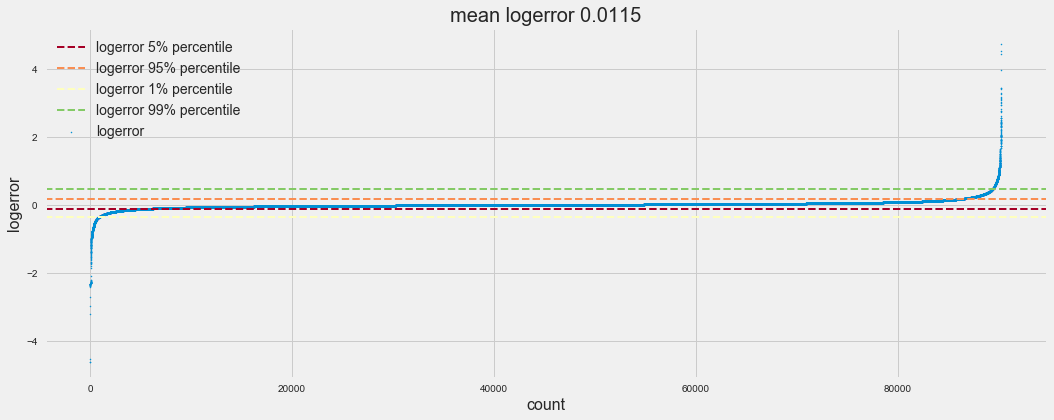

In [22]:
cm = plt.get_cmap('RdYlGn')
c = [cm(i/4) for i in range(6)]

fig, ax = plt.subplots(figsize=(16,6))
ax.scatter(range(train.shape[0]), np.sort(train.logerror.values),label='logerror', s=1)
ax.set_ylabel('logerror',size=16)
ax.set_xlabel('count',size=16)
ax.axhline(np.percentile(train.logerror, 5),linestyle='--',label='logerror 5% percentile', c=c[0], linewidth=2)
ax.axhline(np.percentile(train.logerror, 95),linestyle='--',label='logerror 95% percentile', c=c[1],linewidth=2)
ax.axhline(np.percentile(train.logerror, 1),linestyle='--',label='logerror 1% percentile', c=c[2],linewidth=2)
ax.axhline(np.percentile(train.logerror, 99),linestyle='--',label='logerror 99% percentile', c=c[3],linewidth=2)
ax.legend(fontsize=14)
ax.set_title('mean logerror %.4f'%(train.logerror.mean()), size=20)

## Propertier Data Set

> region columns

In [59]:
region_columns = [i for i in properties.columns if i[:6] == 'region']
region_columns.extend(['longitude','latitude','fips'])
region_columns

['region_city',
 'region_county',
 'region_neighbor',
 'region_zip',
 'longitude',
 'latitude',
 'fips']

### 缺失值

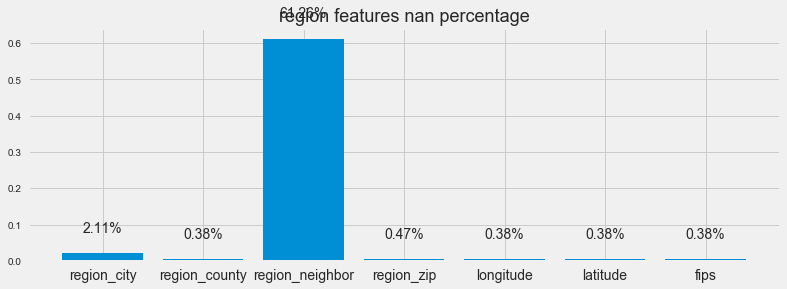

In [54]:
fig, ax = plt.subplots(figsize=(12,4))
ax.bar(range(len(region_columns)),properties[region_columns].isnull().sum()/properties.shape[0])
ax.set_xticks(range(len(region_columns)))
ax.set_xticklabels(region_columns, size=14)
ax.set_title('region features nan percentage',size= 18)

for a,b in zip(range(len(region_columns)), properties[region_columns].isnull().sum()/properties.shape[0]):
    ax.text(a,b+0.05,'%.2f%%'%(b*100), ha='center', va= 'bottom',fontsize=14)

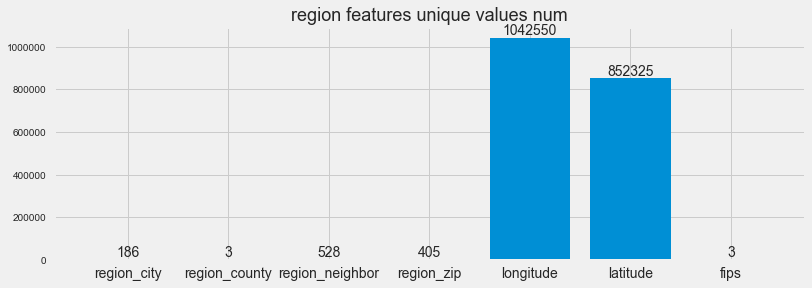

In [55]:
fig, ax = plt.subplots(figsize=(12,4))
ax.bar(range(len(region_columns)), properties[region_columns].nunique())
ax.set_xticks(range(len(region_columns)))
ax.set_xticklabels(region_columns, size=14)
ax.set_title('region features unique values num',size= 18)

for a,b in zip(range(len(region_columns)), properties[region_columns].nunique()):
    ax.text(a,b+0.05,'%d'%(b), ha='center', va= 'bottom',fontsize=14)

### region_county

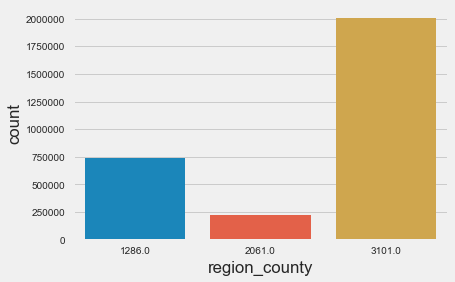

In [56]:
sns.countplot(properties.region_county)

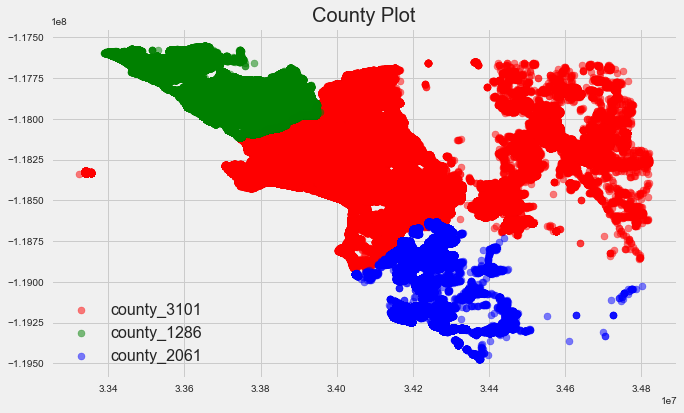

In [57]:
tmp = properties[['region_county','latitude','longitude']].dropna().copy()
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.scatter(tmp[tmp.region_county==3101].latitude,tmp[tmp.region_county==3101].longitude,c='r',label='county_3101',alpha=0.5)
ax.scatter(tmp[tmp.region_county==1286].latitude,tmp[tmp.region_county==1286].longitude,c='g',label='county_1286',alpha=0.5)
ax.scatter(tmp[tmp.region_county==2061].latitude,tmp[tmp.region_county==2061].longitude,c='b',label='county_2061',alpha=0.5)
ax.legend(fontsize=16)
ax.set_title('County Plot', size=20)
del tmp

** region_county 缺省情况 经纬度一致**

In [60]:
properties[(properties.region_county.isnull().astype(bool))&(-properties.latitude.isnull())].shape

(0, 58)

** region_countuy 就是 fips **

In [62]:
properties[['region_county','fips']].drop_duplicates()

,region_county,fips
0,3101.0,6037.0
245,1286.0,6059.0
273,2061.0,6111.0
2973780,NaN,NaN


** region city对应的region county标签有错误的**

In [64]:
properties.groupby('region_city')['region_county'].value_counts().rename(index='count').head()

region_city  region_county
3491.0       3101.0            1076
3980.0       2061.0               6
4406.0       3101.0           21331
5465.0       3101.0           13400
             1286.0              97
Name: count, dtype: int64

** 有少量region_zip 对应两个county**

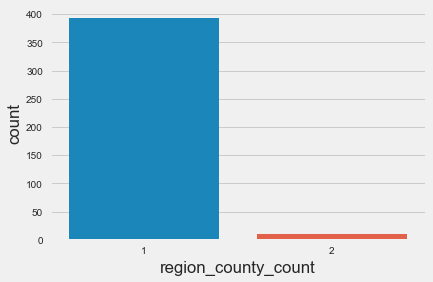

In [72]:
#我晕死。。知乎专栏编辑我一打字chrome就崩溃。。。疯了
#现在在jupyter notebook 打了再复制鬼来了
#解释不会很详细，大家谅解下
#下图是不同region_zip 对应的region_county个数，关系已经很明朗了
sns.countplot(x='region_county_count',
    data=properties.groupby('region_zip')['region_county'].nunique().reset_index().rename(columns={'region_county':'region_county_count'}))

In [76]:
zip_county_count = properties.groupby('region_zip')['region_county'].nunique()
zip_with_2county = zip_county_count[zip_county_count==2].index
zip_with_2county

Float64Index([96116.0, 96183.0, 96185.0, 96186.0, 96190.0, 96247.0, 96339.0,
              96342.0, 96346.0, 96384.0, 96385.0],
             dtype='float64', name='region_zip')

In [78]:
properties[properties.region_zip.isin(zip_with_2county)].groupby('region_zip')['region_county'].value_counts()

region_zip  region_county
96116.0     3101.0            7304
            2061.0             362
96183.0     1286.0            4058
            3101.0              84
96185.0     1286.0           13125
            3101.0              31
96186.0     1286.0           13957
            3101.0            2090
96190.0     3101.0           13525
            1286.0             120
96247.0     3101.0           12389
            1286.0               5
96339.0     3101.0           10377
            2061.0             145
96342.0     3101.0            7768
            2061.0             603
96346.0     3101.0           10862
            2061.0             184
96384.0     2061.0            4608
            3101.0            3049
96385.0     2061.0           11707
            3101.0             412
Name: region_county, dtype: int64

** 
抽取两个zip,把对应的county zip都画出来  
有显著的离群点， 图像来看，zip确实是跨county的
**

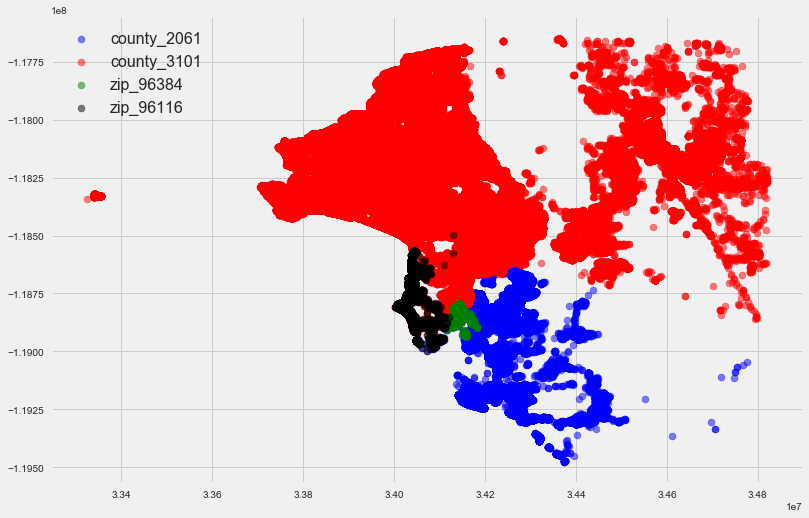

In [81]:
#画个图看看zip 和county 更清洗
tmp = properties[['region_county','region_zip','latitude','longitude']].dropna().copy()
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.scatter(tmp[tmp.region_county==2061].latitude,tmp[tmp.region_county==2061].longitude,c='b',label='county_2061',alpha=0.5)
ax.scatter(tmp[tmp.region_county==3101].latitude,tmp[tmp.region_county==3101].longitude,c='r',label='county_3101',alpha=0.5)
ax.scatter(tmp[tmp.region_zip==96384].latitude,tmp[tmp.region_zip==96384].longitude,c='g',label='zip_96384',alpha=0.5)
ax.scatter(tmp[tmp.region_zip==96116].latitude,tmp[tmp.region_zip==96116].longitude,c='k',label='zip_96116',alpha=0.5)

ax.legend(fontsize=16)
del tmp

** county 和 city**

In [86]:
city_county_count = properties.groupby('region_city')['region_county'].nunique()
city_with_2county = city_county_count[city_county_count>1].index
city_with_2county

Float64Index([ 5465.0,  9840.0, 10608.0, 10734.0, 12447.0, 12520.0, 14634.0,
              15237.0, 18874.0, 18875.0, 24812.0, 34278.0, 41673.0, 44833.0,
              46314.0, 54352.0],
             dtype='float64', name='region_city')

In [93]:
properties[properties.region_city.isin(city_with_2county)].groupby('region_city')['region_county'].value_counts()

region_city  region_county
5465.0       3101.0            13400
             1286.0               97
9840.0       3101.0             7683
             2061.0                4
10608.0      1286.0            16647
             3101.0               29
10734.0      3101.0             6518
             2061.0                2
12447.0      3101.0           670885
             2061.0               40
12520.0      3101.0             7110
             2061.0              361
14634.0      3101.0            20149
             1286.0                4
15237.0      1286.0             4075
             3101.0              234
18874.0      1286.0            13558
             3101.0              226
18875.0      3101.0             1973
             1286.0                9
24812.0      1286.0            30307
             3101.0               12
34278.0      2061.0            38415
             3101.0              359
41673.0      2061.0             4635
             3101.0             3038
44833.0    

In [96]:
city_41673_zip = properties[properties.region_city==41673]['region_zip'].dropna().unique()

array([ 96384.,  96351.,  96116.])

** 选取city41673 和其对应的zip画图  **  
** 有离群点，city对应的zip基本覆盖了city，少量一个city跨越2个county貌似没错**

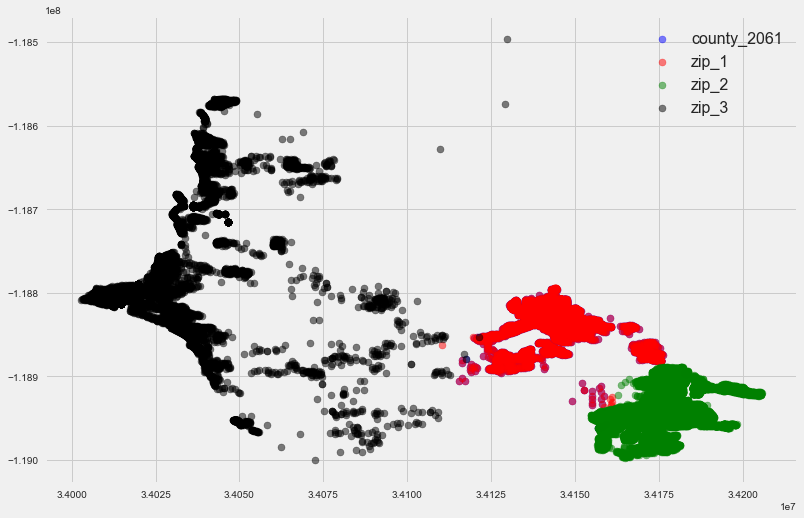

In [100]:
tmp = properties[['region_county','region_city','region_zip','latitude','longitude']].dropna().copy()
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.scatter(tmp[tmp.region_city==41673].latitude,tmp[tmp.region_city==41673].longitude,c='b',label='county_2061',alpha=0.5)
ax.scatter(tmp[tmp.region_zip==96384].latitude,tmp[tmp.region_zip==96384].longitude,c='r',label='zip_1',alpha=0.5)
ax.scatter(tmp[tmp.region_zip==96351].latitude,tmp[tmp.region_zip==96351].longitude,c='g',label='zip_2',alpha=0.5)
ax.scatter(tmp[tmp.region_zip==96116].latitude,tmp[tmp.region_zip==96116].longitude,c='k',label='zip_3',alpha=0.5)

ax.legend(fontsize=16)
del tmp

### region_city

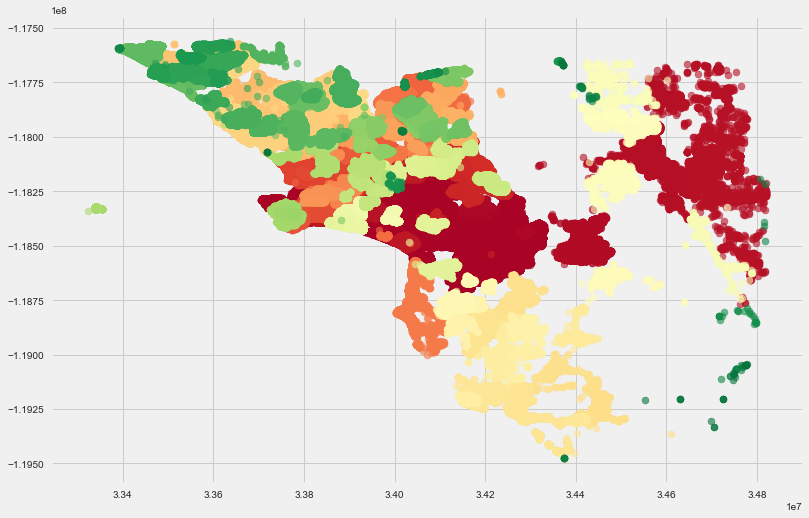

In [106]:
#看看regin_countu & region_city的关系
cm = plt.get_cmap('RdYlGn')
c = [cm(i/190) for i in range(186)]
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
x=0
for city in properties.region_city.dropna().unique():
    ax.scatter(properties[properties.region_city==city].latitude, 
              properties[properties.region_city==city].longitude,
              c = c[x],alpha=0.6)
    x+=1

** city & zip 不是一一对应**

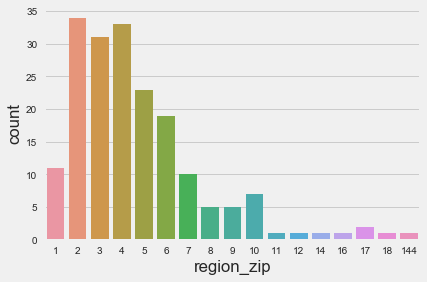

In [110]:
sns.countplot(properties.groupby('region_city')['region_zip'].nunique())

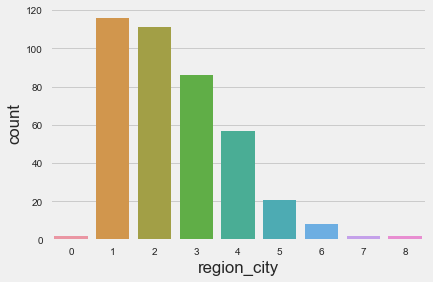

In [111]:
sns.countplot(properties.groupby('region_zip')['region_city'].nunique())

** city zip 没有什么对应关系，选一个city看看 **

In [116]:
properties[properties.region_city==54311].region_zip.unique()

array([ 96373.,  96374.,  96352.,  96401.,  96377.,  96378.,  96403.,
        96346.,  96368.,  97298.,  96395.])

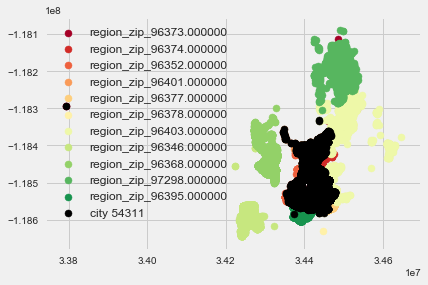

In [117]:
#city 和 zip 没有什么对应关系
cm = plt.get_cmap("RdYlGn")
col = [cm(float(i)/(11)) for i in range(11)]
x=0
for i in properties[properties.region_city==54311].region_zip.unique():
    #print('#%s8E90'%(str(hex(x))[1:]))
    plt.scatter(properties[properties.region_zip==i]['latitude'],properties[properties.region_zip==i]['longitude'],
            c=col[x],label='region_zip_%f'%(i))
    x+=1
plt.scatter(properties[properties.region_city==54311]['latitude'],properties[properties.region_city==54311]['longitude'],
            c='k',label='city 54311')
plt.legend(fontsize=12)

** 彩蛋= = 小猫咪**

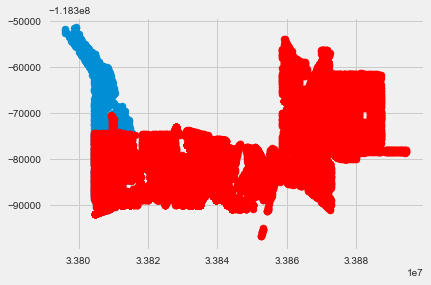

In [10]:
#最后，再来个福利，这个小猫咪可爱否？
plt.scatter(properties[properties.region_neighbor==115657]['latitude'],properties[properties.region_neighbor==115657]['longitude'])
plt.scatter(properties[properties.region_city==33612.0]['latitude'],properties[properties.region_city==33612.0]['longitude'],c='r')

** city & neighbor **

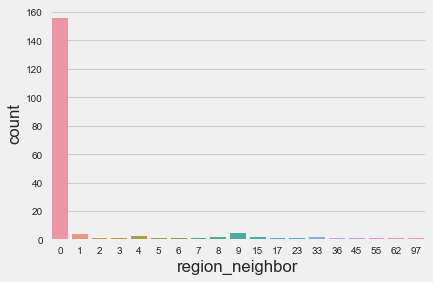

In [112]:
sns.countplot(properties.groupby('region_city')['region_neighbor'].nunique())

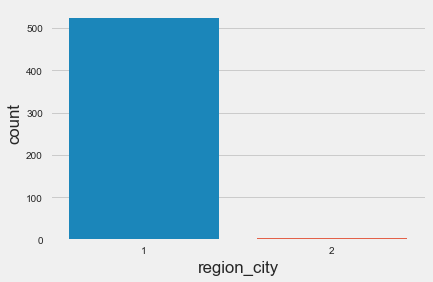

In [113]:
sns.countplot(properties.groupby('region_neighbor')['region_city'].nunique())

** neighbor -> city 是单射，可能描述的是city里面的各种小区域, 选一个city看看**

In [114]:
properties[properties.region_city==54311].region_neighbor.unique()

array([ 37739.,  26134.,   6952.,  48200.])

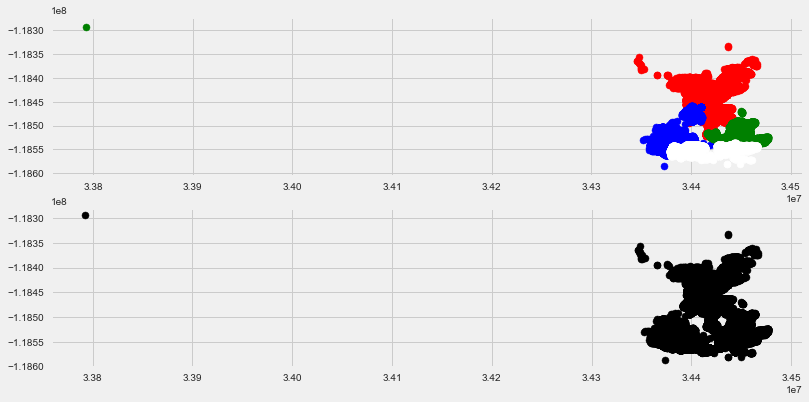

In [115]:
# neighbor 在city 中
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(211)
color = ['r','b','g','w']
x = 0
for i in properties[properties.region_city==54311].region_neighbor.unique():
    ax1.scatter(properties[properties.region_neighbor==i]['latitude'],properties[properties.region_neighbor==i]['longitude'],c=color[x])
    x+=1
ax2 = fig.add_subplot(212)
ax2.scatter(properties[properties.region_city==54311]['latitude'],properties[properties.region_city==54311]['longitude'],
            c='k',label='city 54311')

## Area

In [4]:
area_columns = [i for i in list(properties.columns) if 'area' in i]
area_columns

[]

** area nan **

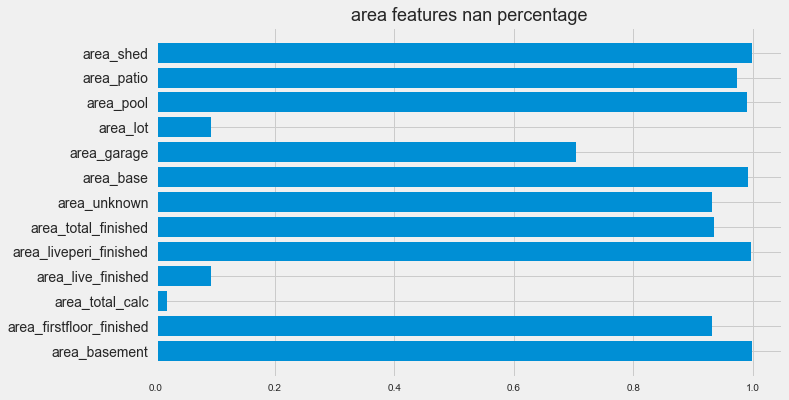

In [138]:
#Area 分析，看看变量缺省情况
fig, ax = plt.subplots(figsize=(10,6))
ax.barh(range(len(area_columns)),properties[area_columns].isnull().sum()/properties.shape[0])
ax.set_yticks(range(len(area_columns)))
ax.set_yticklabels(area_columns, size=14)
ax.set_title('area features nan percentage',size= 18)

# for a,b in zip(range(len(area_columns)), properties[area_columns].isnull().sum()/properties.shape[0]):
#     ax.text(a,b,'%.2f%%'%(b*100), ha='center', va= 'bottom',fontsize=14)

/Users/zhouzhirui/anaconda3/lib/python3.6/site-packages/seaborn/matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
/Users/zhouzhirui/anaconda3/lib/python3.6/site-packages/seaborn/matrix.py:151: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


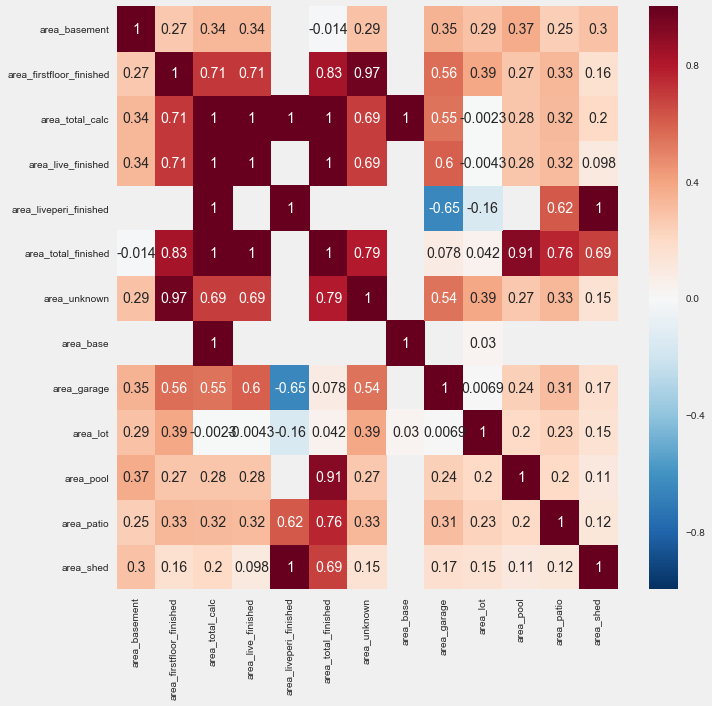

In [122]:
#相关性分析
fig,ax= plt.subplots(figsize=(10,10))
sns.heatmap(properties[area_columns].corr(),ax=ax,annot=True)

In [129]:
properties[['area_total_calc','area_total_finished']].dropna().corr()

,area_total_calc,area_total_finished
area_total_calc,1.000000,0.999994
area_total_finished,0.999994,1.000000


** 这两个变量几乎没有区别！**

In [124]:
properties[['area_total_calc','area_base']].dropna().corr()

,area_total_calc,area_base
area_total_calc,1.0,1.0
area_base,1.0,1.0


** 还有这个。。。**

/Users/zhouzhirui/anaconda3/lib/python3.6/site-packages/seaborn/matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
/Users/zhouzhirui/anaconda3/lib/python3.6/site-packages/seaborn/matrix.py:151: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


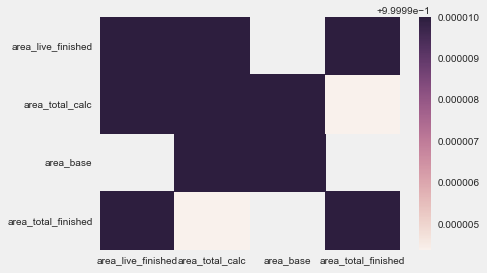

In [8]:
sns.heatmap(properties[['area_live_finished','area_total_calc','area_base','area_total_finished']].corr())

### Num features

In [139]:
num_columns = [i for i in properties.columns if 'num' in i]
num_columns

['num_bathroom',
 'num_bedroom',
 'num_bathroom_calc',
 'num_fireplace',
 'num_bath',
 'num_garage',
 'num_pool',
 'num_room',
 'num_75_bath',
 'num_unit',
 'num_story']

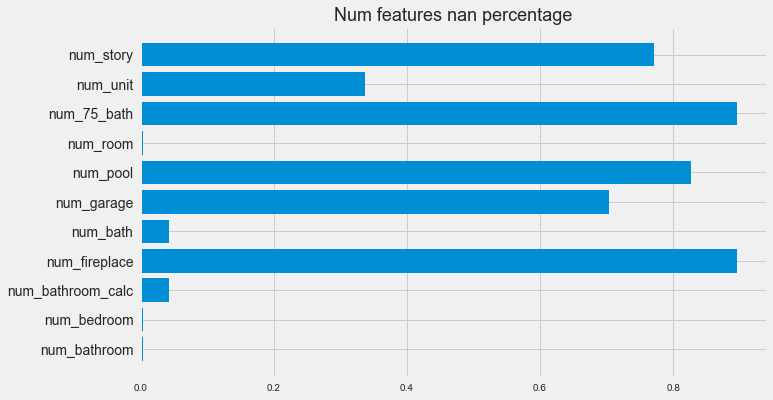

In [140]:
#。。。好累，不能打字，贴图也很慢，这集先上简略版，下期上完整版- -。。。
# Num类特征缺省情况
fig, ax = plt.subplots(figsize=(10,6))
ax.barh(range(len(num_columns)),properties[num_columns].isnull().sum()/properties.shape[0])
ax.set_yticks(range(len(num_columns)))
ax.set_yticklabels(num_columns, size=14)
ax.set_title('Num features nan percentage',size= 18)

/Users/zhouzhirui/anaconda3/lib/python3.6/site-packages/seaborn/matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
/Users/zhouzhirui/anaconda3/lib/python3.6/site-packages/seaborn/matrix.py:151: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


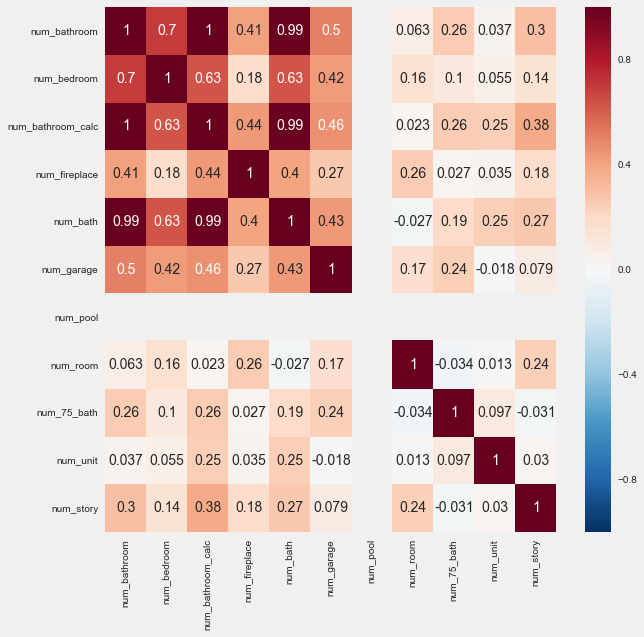

In [141]:
#num 类特征相关矩阵
fig = plt.figure(figsize=(9,9))
sns.heatmap(properties[num_columns].corr(),annot=True)

In [142]:
properties[['num_bathroom','num_bath','num_bathroom_calc']].corr()

,num_bathroom,num_bath,num_bathroom_calc
num_bathroom,1.00000,0.98736,1.00000
num_bath,0.98736,1.00000,0.98736
num_bathroom_calc,1.00000,0.98736,1.00000


** 很奇葩- -**

### Zoning features

In [144]:
zoning_columns = [i for i in properties.columns if 'zoning' in i]
zoning_columns

['zoning_landuse_county', 'zoning_landuse', 'zoning_property']

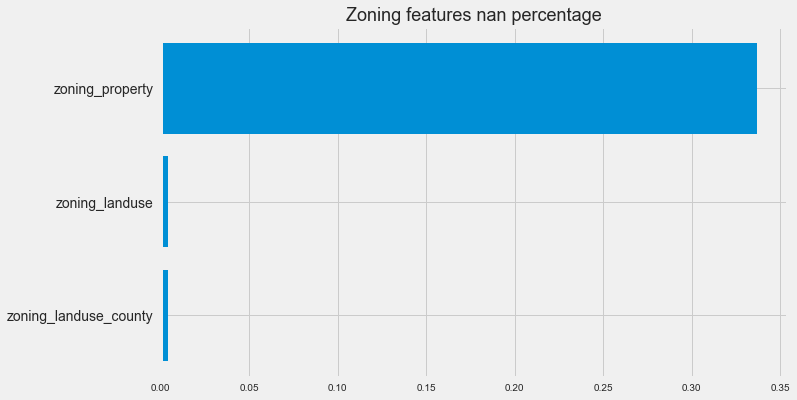

In [145]:
#zoning类特征缺省情况
fig, ax = plt.subplots(figsize=(10,6))
ax.barh(range(len(zoning_columns)),properties[zoning_columns].isnull().sum()/properties.shape[0])
ax.set_yticks(range(len(zoning_columns)))
ax.set_yticklabels(zoning_columns, size=14)
ax.set_title('Zoning features nan percentage',size= 18)

### tax features

In [152]:
tax_columns = [i for i in properties.columns if 'tax' in i]
tax_columns

['tax_building',
 'tax_total',
 'tax_year',
 'tax_land',
 'tax_property',
 'tax_delinquency',
 'tax_delinquency_year']

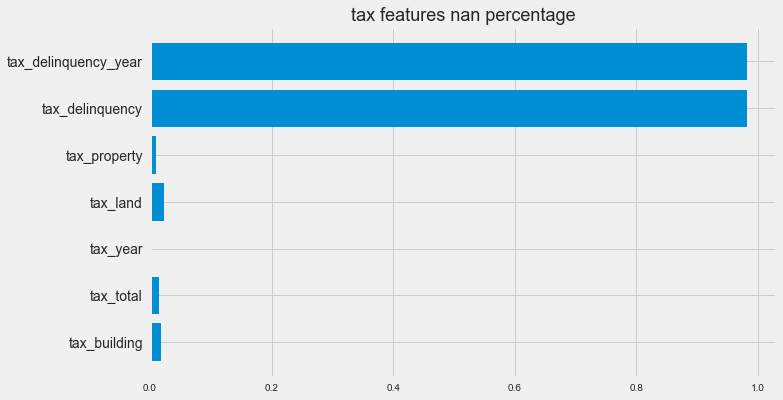

In [154]:
#tax类特征 na count
fig, ax = plt.subplots(figsize=(10,6))
ax.barh(range(len(tax_columns)),properties[tax_columns].isnull().sum()/properties.shape[0])
ax.set_yticks(range(len(tax_columns)))
ax.set_yticklabels(tax_columns, size=14)
ax.set_title('tax features nan percentage',size= 18)

/Users/zhouzhirui/anaconda3/lib/python3.6/site-packages/seaborn/matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
/Users/zhouzhirui/anaconda3/lib/python3.6/site-packages/seaborn/matrix.py:151: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


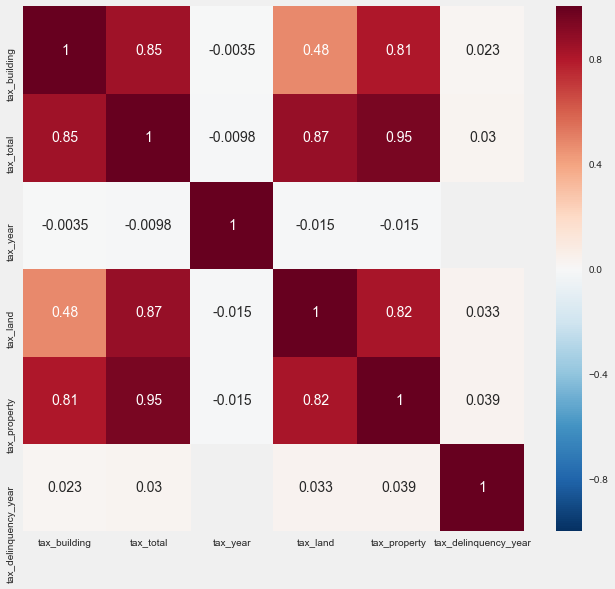

In [159]:
fig = plt.figure(figsize=(10,9))
sns.heatmap(properties[tax_columns].corr(),annot=True)

### other features

In [161]:
other_features = list(properties.columns.values)
def remove_list(x,y):
    for i in y:
        x.remove(i)
    return x
other_features = remove_list(other_features, area_columns)
other_features = remove_list(other_features, region_columns)
other_features = remove_list(other_features, zoning_columns)
other_features = remove_list(other_features, num_columns)
other_features = remove_list(other_features, tax_columns)
other_features = remove_list(other_features, ['parcelid'])
other_features

['aircon',
 'architectural_style',
 'framing',
 'quality',
 'deck',
 'flag_tub',
 'heating',
 'pooltypeid10',
 'pooltypeid2',
 'pooltypeid7',
 'rawcensustractandblock',
 'story',
 'material',
 'build_year',
 'flag_fireplace',
 'censustractandblock']

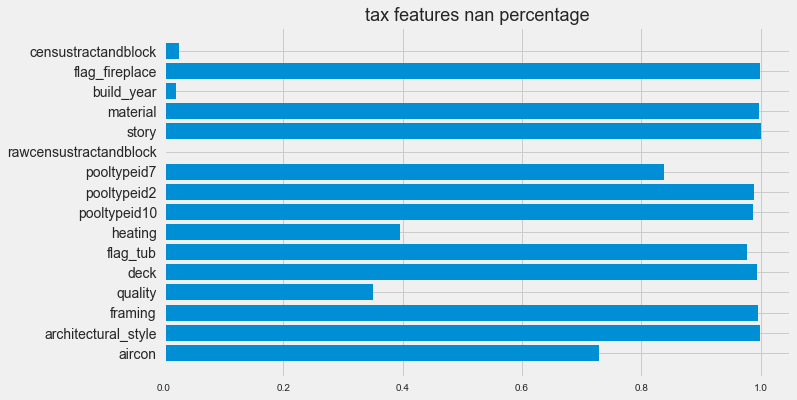

In [162]:
fig, ax = plt.subplots(figsize=(10,6))
ax.barh(range(len(other_features)),properties[other_features].isnull().sum()/properties.shape[0])
ax.set_yticks(range(len(other_features)))
ax.set_yticklabels(other_features, size=14)
ax.set_title('tax features nan percentage',size= 18)